## The HealthBot Prototype
Your task is to create a LangGraph-based workflow for the HealthBot that includes the following functionality:

Ask the patient what health topic or medical condition they'd like to learn about.  
Use the Tavily search engine (via LangChain community tool) to find relevant, up-to-date medical information on the topic.  
Summarize the Tavily search results into a patient-friendly explanation.  
Present the summarized information to the patient and allow them to read it.  
Prompt the patient to indicate when they're ready for a comprehension check.  
Generate a single, relevant quiz question based on the provided information.  
Present the quiz question to the patient.  
Allow the patient to enter their answer to the quiz question.  
Evaluate the patient's response, providing a grade and explanation. The explanation should include relevant citations from the summary to reinforce learning.  
Present the grade and explanation to the patient.  
Ask if the patient would like to learn about another health topic or exit the session.  
Either restart the flow for a new topic or end the session. Ensure that the state is reset when starting a new topic to maintain privacy and accuracy.

In [3]:
# import libs
import time
from langgraph.graph import MessagesState, START, StateGraph, END
from langgraph.graph.message import MessagesState
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig

from IPython.display import Image, display

In [ ]:
# define llm, State and helper functions
def display_text_to_user(text):
    print(text)
    time.sleep(1) # wait for it to render before asking for input or it'll never show up.

def ask_user_for_input(input_description):
    response = input(input_description)
    return response

class State(MessagesState):
    topic: str
    tavily_raw: str
    summary: str
    question: str
    answer: str
    marking: str

model = ChatOpenAI(model="gpt-4o-mini",
                   temperature=0,
                   streaming=True
)

workflow = StateGraph(State)
memory = MemorySaver()


In [ ]:
# define nodes

def ask_for_topic(state):
    return tavily_searches_topic
    # welcome and prompt for topic
    # save topic

def tavily_searches_topic():
    return summary_of_topic
    # tavily searches for topic
    # saves results to tavily_raw

def summary_of_topic():
    return ask_a_question
    # llm summarises (save to summary), writes question (save to question)
    # print summary, pause for Y showing ready to continue

def ask_a_question():
    return mark_the_answer
    # print question and wait for response
    # save answer

def mark_the_answer():
    return restart_or_quit
    # llm compares question and user answer
    # writes response with "correct!", "ooh, not quite!" and commentary
    # save to marking

def restart_or_quit():
    restart_or_end_condition

def restart_or_end_condition(state):
    user_input = ask_user_for_input("Do you want to ask another question? (Y/N): ")
    if user_input.strip().upper() == "Y":
        return "ask_for_topic"
    else:
        display_text_to_user("Thank you for participating.")
        return END
    # reset state
    # conditional paths to end/ask_for_topic




ValueError: Graph must have an entrypoint: add at least one edge from START to another node

In [ ]:
# define graph - nodes and edges

workflow.add_node("ask_for_topic", ask_for_topic)
workflow.add_node("tavily_searches_topic", tavily_searches_topic)
workflow.add_node("summary_of_topic", summary_of_topic)
workflow.add_node("ask_a_question", ask_a_question)
workflow.add_node("mark_the_answer", mark_the_answer)
workflow.add_node("restart_or_quit", restart_or_quit)

workflow.add_edge(START, "ask_for_topic")
workflow.add_edge("ask_for_topic", "tavily_searches_topic")
workflow.add_edge("tavily_searches_topic", "summary_of_topic")
workflow.add_edge("summary_of_topic", "ask_a_question")
workflow.add_edge("ask_a_question", "mark_the_answer")
workflow.add_edge("mark_the_answer", "restart_or_quit")
workflow.add_conditional_edges(
    source="restart_or_quit",
    path=restart_or_end_condition,
    path_map=["ask_for_topic", END]
)


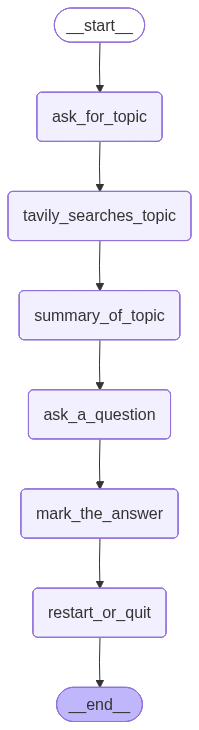

In [ ]:
# show graph

app = workflow.compile(checkpointer=memory)
display(Image(app.get_graph().draw_mermaid_png()))



In [ ]:
# config, initial state

config = RunnableConfig(recursion_limit=2000, configurable={"thread_id": "2"})


initial_state = {"messages": [],}

In [ ]:
# run it

app.invoke(
    initial_state,
    config,
)